## **Systematic Equity Selection From Earnings Data Analysis**
### FINM 33150 - Quantitative Trading Strategies
### REDACTED, REDACTED, Jared Szajkowski (REDACTED)

## **Abstract**

The final project seeks to develop a systematic trading/investment strategy that takes advantage of the time-tested market ideas that the market tends to increase in price/value over time, positive earnings growth tends to increase company valuation, companies with positive earnings growth tend to exhibit upward price momentum. When companies have lower earnings, they tend to have lower valuations which provides an opportunity for the value factor to take effect.

## **Introduction / Goals**

The basic goals for the trading strategy are as follows:

**1. Identify the investment universe**

To establish the universe of available equities, we will use the following criteria:

* Restrict equities to companies with a market cap greater than $ 10 billion
* Equities must be publicly traded on U.S. exchanges
* Restrict equities to companies that have positive earnings per share (EPS)

**2. Generate excess returns**

Based upon the idea that companies experiencing earnings growth will subsequently increase in valuation, we will implement the following quantitative process:

* Identify companies with earnings growth on a year over year time-frame

**3. Capture outlier growth**

We will also seek to identify equities that are experiencing outsized growth (so-called "outliers"), by implementing the following ideas:

* Identify the 50 companies on an annual basis that have the highest percentage increase in year over year earnings growth

**4. Systematic risk management**

The strategy will employ disciplined systematic risk management to perform the following:

* Implement a trailing stop style stop-loss strategy for a maximum loss of 10% on any given position
* Equal weight initial position sizing
* Reset position sizing annually when the portfolio turns over
* Gains are harvested and moved off book (but analyzed as part of returns)

## **Relevant Literature**

We have identified the following publications that provide academic insights into the proposed investment strategy:

* **Valeyre, Sebastien. "Optimal trend following portfolios.", 2022.**

Summary: Emphasizes the profitability of trend following strategies, despite the market efficiency hypothesis, and highlights their wide usage among professional asset managers due to their simplicity and effectiveness.

* **Fink, Josef. "A review of the Post-Earnings-Announcement Drift." _Journal of Behavioral and Experimental Finance_, 2020.**

Summary: Provides a comprehensive overview of the PEAD phenomenon, summarizing research on how stock prices continue to drift in the direction of an earnings surprise for an extended period. It discusses the inefficiency of markets to fully adjust stock prices instantaneously after earnings announcements, contrary to the efficient market hypothesis.​

* **Chan, Konan & Chan, Louis K. C. & Jegadeesh, Narasimhan & Lakonishok, Josef. "Earnings Quality and Stock Returns." _The Journal of Business_, 2006.**

Summary: Discusses the relationship between the quality of a company's earnings, as indicated by its accruals, and its stock performance. It highlights that high accruals, suggesting low-quality earnings, are associated with poorer future stock returns. This suggests a market underreaction to the information conveyed by accrual levels. The analysis includes examining earnings manipulation, investor biases about future growth, and how these factors might influence stock returns.

* **Moskowitz, Tobias & Ooi, Yao Hua & Pedersen, Lasse H. "Time Series Momentum." _The Initiative on Global Markets_, 2011.**

From the abstract:

 "We document significant “time series momentum” in equity index, currency, commodity, and bond futures for each of the 58 liquid instruments we consider. We find persistence in returns for 1 to 12 months that partially reverses over longer horizons, consistent with sentiment theories of initial under-reaction and delayed over-reaction. A diversified portfolio of time series momentum strategies across all asset classes delivers substantial abnormal returns with little exposure to standard asset pricing factors and performs best during extreme markets. Examining the trading activities of speculators and hedgers, we find that speculators profit from time series momentum at the expense of hedgers."

## **Methodology**

The methodology is broken down into the following parts:

* Section 1: Python Imports
* Section 2: Python Functions
* Section 3: Acquire Data
* Section 4: Initial Data Investigation
* Section 5: Develop Data
* Section 5a: Earnings Per Share Signals
* Section 5b: Identify Trades
* Section 5c: Entry Price & Date
* Section 5d: Implement Stop Loss
* Section 5e: Exit Price & Date
* Section 5f: Position Sizing
* Section 5g: Profit & Loss
* Section 5h: Portfolio Value
* Section 5j: Funding Costs
* Section 5k: Returns

### **Section 1: Imports**

The following libraries are required for our functions:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import qtsprojectfunctions

### **Section 2: Python Functions**

All functions are imported through the `qtsprojectfunctions` method above.

### **Section 3: Acquire Data**

We will start off by pulling in the databases for QUOTEMEDIA/PRICES, ZACKS/FC, ZACKS/SHRS, and ZACKS/MKTV. These databases will provide the required data for ticker, price, earnings per share, filing date, shares outstanding, and market valuation.

In [2]:
from qtsprojectfunctions import fetch_qm_prices, fetch_zacks_fc, fetch_zacks_shrs, fetch_zacks_mktv
qm_prices = fetch_qm_prices()
# PRICES_20240304.zip
zacks_fc = fetch_zacks_fc()
# FC_20240129.zip
zacks_shrs = fetch_zacks_shrs()
# SHRS_20240304.zip
zacks_mktv = fetch_zacks_mktv()
# MKTV_20240304.zip

Skipping any possible download of QUOTEMEDIA/PRICES
Skipping any possible download of ZACKS/FC
Skipping any possible download of ZACKS/SHRS
Skipping any possible download of ZACKS/MKTV


Next we will merge the three databases from ZACKS together to form our fundamental dataset:

In [3]:
fundamental_data = pd.DataFrame()
fundamental_data = pd.merge(zacks_fc, zacks_shrs, left_on=['ticker', zacks_fc.index], right_on=['ticker', zacks_shrs.index], how='outer').rename(columns={'key_1':'per_end_date'}).set_index('per_end_date')
fundamental_data = fundamental_data.merge(zacks_mktv, left_on=['ticker', fundamental_data.index], right_on=['ticker', zacks_mktv.index], how='outer')
fundamental_data = fundamental_data[['ticker', 'eps_diluted_net', 'shares_out', 'mkt_val', 'filing_date']]
fundamental_data['filing_date'] = pd.to_datetime(fundamental_data['filing_date'])
fundamental_data = fundamental_data[(fundamental_data['filing_date'] > '2008') & (fundamental_data['filing_date'] < '2024')]

Next, we will filter out the price data for the data range to be analyzed (January 1, 2008 through December 31, 2023) and drop unused columns:

In [4]:
prices = qm_prices[(qm_prices.index >= '2008-01-01') & (qm_prices.index <= '2023-12-31')]
prices = prices[['ticker', 'adj_open', 'adj_high', 'adj_low', 'adj_close']].reset_index()
prices['date'] = pd.to_datetime(prices['date'])

And merge the prices and fundamental dataframes together:

In [5]:
merged_data = pd.merge(prices.sort_values('date'), 
                       fundamental_data.sort_values('filing_date'),
                       left_on=['ticker', 'date'],
                       right_on=['ticker', 'filing_date'],
                       how='left').set_index('date')
# start date 01/01/2010
merged_data = merged_data[merged_data.index >= '2010']
qtsprojectfunctions.dp(2)
qtsprojectfunctions.df_info(merged_data)

There are  31204695  rows and  9  columns
The columns and data types are:
ticker                     object
adj_open                  float64
adj_high                  float64
adj_low                   float64
adj_close                 float64
eps_diluted_net           float64
shares_out                float64
mkt_val                   float64
filing_date        datetime64[ns]
dtype: object


ticker  adj_open  adj_high  adj_low  adj_close  eps_diluted_net  \
date                                                                         
2010-01-01  ROICU     10.40     10.40    10.40      10.40              NaN   
2010-01-01   ALBO    520.80    520.80   520.80     520.80              NaN   
2010-01-01    ERS      1.07      1.07     1.07       1.07              NaN   
2010-01-04    EEB     34.88     35.23    34.71      35.23              NaN   
2010-01-04     IP     15.93     16.08    15.84      15.93              NaN   

            shares_out  mkt_val filing_date  
date                                         
2010-01-01         NaN      NaN         NaT  
2010-01-01         NaN      NaN         NaT  
2010-01-01         NaN      NaN         NaT  
2010-01-04         NaN      NaN         NaT  
2010-01-04         NaN      NaN         NaT

THis dataframe provides the basic building blocks for the strategy. We have each equity defined by `ticker`, the open/high/low/close adjusted prices, earnings per share, shares outstanding, market capitalization definded as `mkt_val`, and the filing date of the report.

### **Section 4: Initial Data Investigation**

We will now perform some initial data investigation to see what kind of relationships exist between EPS and price. Starting with NVDA:

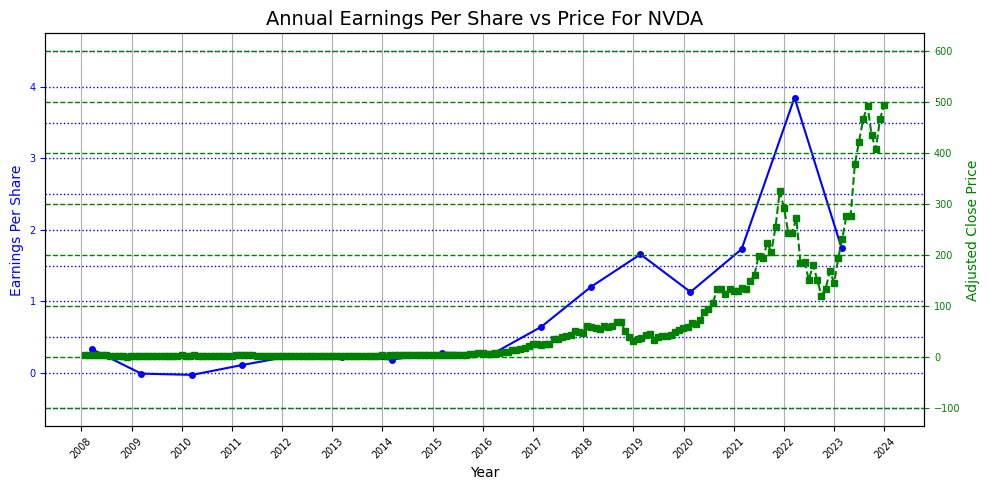

In [6]:
qtsprojectfunctions.plot_eps_price(fundamental_data, prices, 'NVDA')

In the first plot, we can visually see that there is a correlation between EPS and price.

Let's now check AAPL:

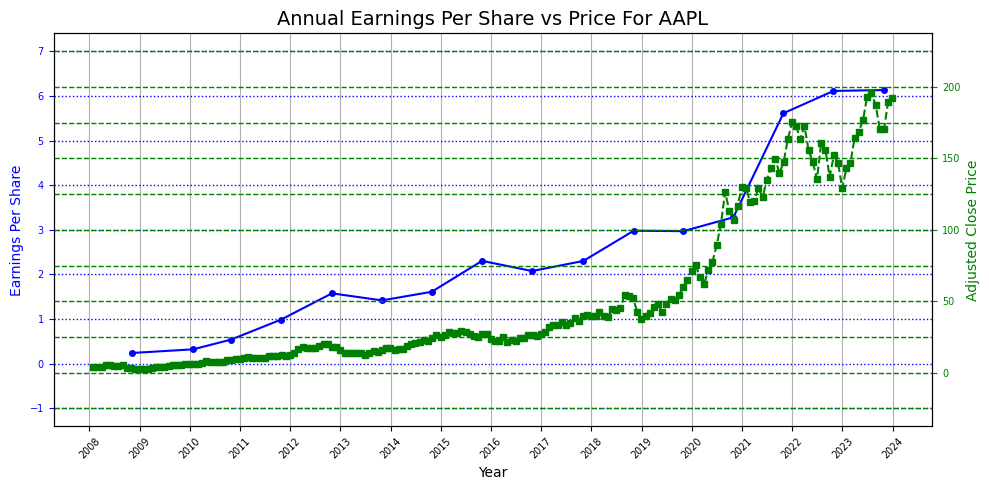

In [7]:
qtsprojectfunctions.plot_eps_price(fundamental_data, prices, 'AAPL')

Again, there appears to be a correlation between and increase in price and and increase in EPS. Now, GOOGL:

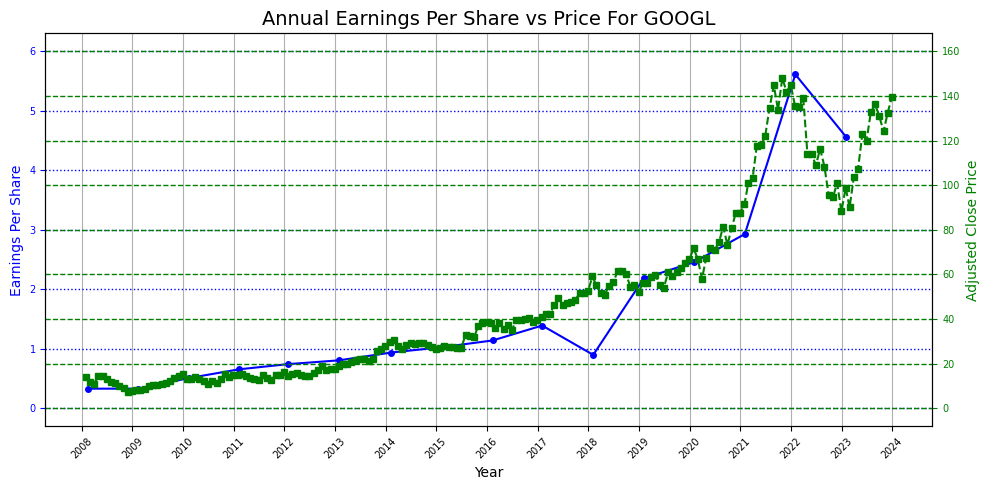

In [8]:
qtsprojectfunctions.plot_eps_price(fundamental_data, prices, 'GOOGL')

GOOGL also appears to have a correlation between EPS and price. So far we have only looked at large cap tech stocks, so let's check something else, such as PFE:

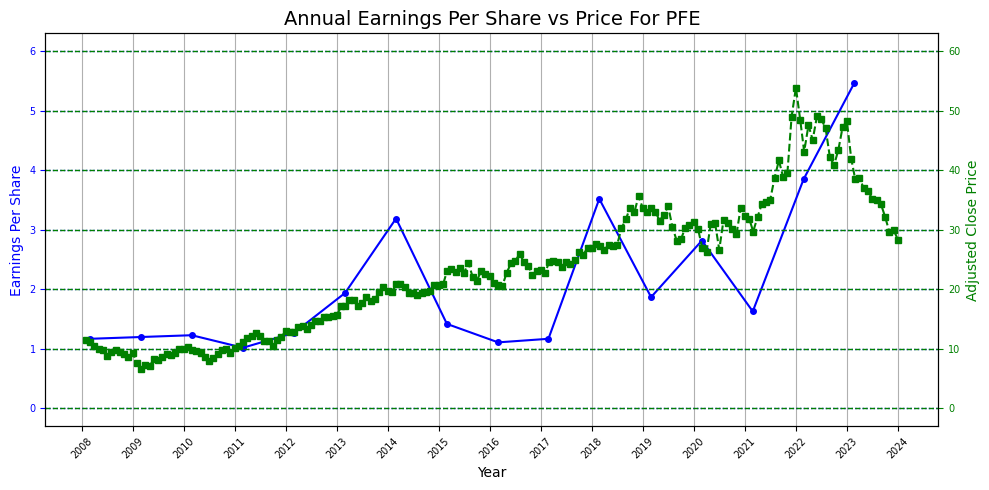

In [9]:
qtsprojectfunctions.plot_eps_price(fundamental_data, prices, 'PFE')

Again, there is a relationship between EPS and price, but it does not appear to be as strong as NVDA, AAPL, or GOOG. Let's look at INTC:

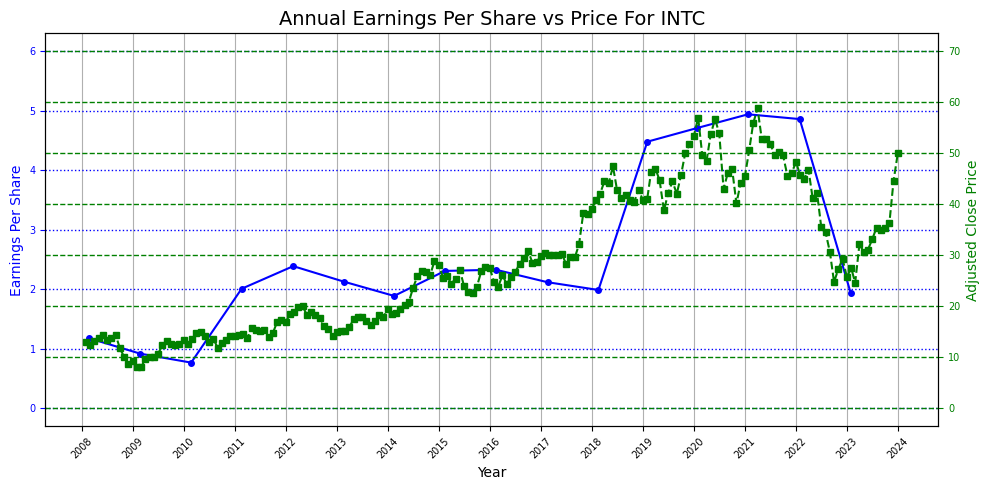

In [10]:
qtsprojectfunctions.plot_eps_price(fundamental_data, prices, 'INTC')

One more example, WM:

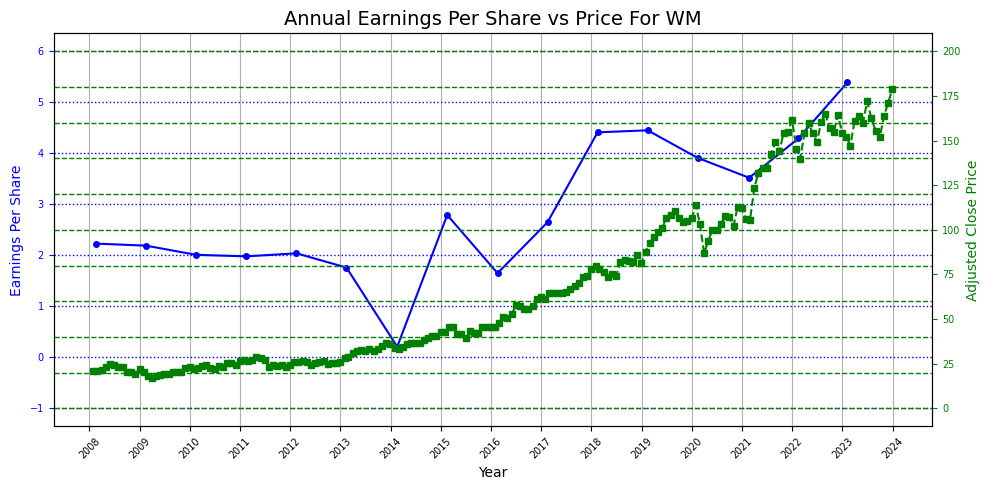

In [11]:
qtsprojectfunctions.plot_eps_price(fundamental_data, prices, 'WM')

Based on the above, we can say with a very reasonable amount of confidence that there is a relationship between EPS and price. This confirms our initial hypothesis that growth in earnings drives price appreciation. From this initial data we will proceed with identifying trading signals, capital allocation constraints, and risk management process. We know that the market takes time to process changes in fundamental data and price appreciation may not occur for some months following a positive earnings release. For this reason we will delay our buy signals to avoid short term volatility and also diversify our holdings across many equities to avoid concentration risk.

### **Section 5: Develop Data**

#### **Section 5a: Earnings Per Share Signals**

Next, we will develop the trading signals that will govern the strategy.

We will start off by completing the following with the data:

* Removing any rows from the dataframe that do not have a filing date
* Filter out for positive earnings
* Filter out for market caps that are only greater than $10 billion

In [12]:
# Keep only data with a filing date
signals_df = merged_data[merged_data['filing_date'].notna()]

# Fill missing values with 0
signals_df['eps_diluted_net'] = signals_df['eps_diluted_net'].fillna(0)

# Filter out for positive EPS only
signals_df = signals_df[signals_df['eps_diluted_net'] > 0]

# Calc market cap
signals_df['mkt_val'] = signals_df['adj_close'] * signals_df['shares_out']

# Keep market cap only greater than 10 bil
signals_df = signals_df[signals_df['mkt_val'] >= 10000]

Let's check to see how many unique tickers this leaves us:

In [13]:
len(signals_df['ticker'].unique())

863

From the above, we can see that there are 863 unique tickers that satisfy the criteria. 

Next, we will perform the following:

* Group the data by 'ticker'
* Shift the EPS values
* Calculate the annual percent change in earnings per share from filing date to filing date
* Shift the adjusted close prices
* Calculate the the annual percent change in adjusted close price from filing date to filing date

In [14]:
# Find % change in earnings 
sorted_df = signals_df.sort_values(by = ['ticker', 'date'])

# Shift EPS data
sorted_df['previous_eps_diluted_net'] = sorted_df.groupby('ticker')['eps_diluted_net'].shift(1)

# Calc the change in EPS
sorted_df['pct_change_eps_diluted_net'] = (sorted_df['eps_diluted_net'] - sorted_df['previous_eps_diluted_net']) / sorted_df['previous_eps_diluted_net']

# Shift adjusted close prices
sorted_df['previous_adj_close'] = sorted_df.groupby('ticker')['adj_close'].shift(1)

# Calculate change in price
sorted_df['pct_change_adj_close'] = (sorted_df['adj_close'] - sorted_df['previous_adj_close']) / sorted_df['previous_adj_close']

# Drop any na values
sorted_df.dropna(subset=['previous_eps_diluted_net'], inplace=True)

Next, we will merge the sorted dataframe with the signals dataframe:

In [15]:
signals_df = signals_df.merge(sorted_df[['ticker', 'previous_eps_diluted_net', 'pct_change_eps_diluted_net']],
                              left_on=['ticker', signals_df.index], right_on=['ticker', sorted_df.index], 
                              how='left').rename(columns={'key_1':'date'}).set_index('date')

qtsprojectfunctions.dp(2)
qtsprojectfunctions.df_info(signals_df)

There are  6225  rows and  11  columns
The columns and data types are:
ticker                                object
adj_open                             float64
adj_high                             float64
adj_low                              float64
adj_close                            float64
eps_diluted_net                      float64
shares_out                           float64
mkt_val                              float64
filing_date                   datetime64[ns]
previous_eps_diluted_net             float64
pct_change_eps_diluted_net           float64
dtype: object


ticker  adj_open  adj_high  adj_low  adj_close  eps_diluted_net  \
date                                                                         
2010-01-22   ADBE     35.62     35.82    34.35      34.38             0.73   
2010-01-25   AAPL      6.12      6.19     6.05       6.14             0.32   
2010-01-26    NVS     29.32     29.47    29.19      29.41             3.69   
2010-01-29   ISRG     37.27     37.44    36.32      36.45             0.66   
2010-01-29   AMZN      6.47      6.58     6.19       6.26             0.10   

            shares_out   mkt_val filing_date  previous_eps_diluted_net  \
date                                                                     
2010-01-22      523.76  18006.87  2010-01-22                       NaN   
2010-01-25    25082.88 153997.96  2010-01-25                       NaN   
2010-01-26     2271.20  66798.91  2010-01-26                       NaN   
2010-01-29      343.73  12529.34  2010-01-29                       NaN   
2010-01-29     8659.66  54169.93  2010-01-29                       NaN   

            pct_change_eps_diluted_net  
date                                    
2010-01-22                         NaN  
2010-01-25                         NaN  
2010-01-26                         NaN  
2010-01-29                         NaN  
2010-01-29                         NaN

The above dataframe contains the key data for EPS that we will use to develop the trading strategy.

#### **Section 5b: Identify Trades**

Next, we will identify the 50 trades that we want to make on an annual basis. These 50 trades consist of the 50 largest changes in year over year earnings per share by percentage. We will do this for every year from 2011 through 2023, for 13 years. These are the actions to take with our data:

* Filter out for filing date after 2010 (so keep data beginning in 2011)
* Set variable for number of annual trades
* Group data by filing year
* Find the 50 largest year over year changes by percentage in EPS

In [16]:
# Copy dataframe
trades_to_make = signals_df.copy().dropna()

# using filing date here to make sure the company did actually file in the previous year and that we actually have the data
trades_to_make['filing_year'] = pd.to_datetime(trades_to_make['filing_date']).dt.year

# Filter out filing date for after 2010
trades_to_make = trades_to_make[trades_to_make['filing_year'] > 2010]

# Set number of trades to handle on an annual basis
num_largest = 50

# Group by filing year, and then keep the 50 largest percent changes
top_50_trades_per_year = trades_to_make.groupby('filing_year').apply(lambda x: x.nlargest(num_largest, 'pct_change_eps_diluted_net')).reset_index(drop=True)

# Keep only needed columns
top_50_trades_per_year = top_50_trades_per_year[['ticker', 'adj_close', 'eps_diluted_net', 'previous_eps_diluted_net', 
                                                 'pct_change_eps_diluted_net', 'filing_date', 'filing_year']]

# Rename adjsuted close to avoid confusion later
top_50_trades_per_year.rename(columns = {'adj_close':'adj_close_filing_date'}, inplace = True)

Next, we will merge the trades dataframe with the prices dataframe, which will provide us a dataframe that includes daily price data for the entire year for every trade, with the following actions:

* Create a column for trade year
* Merge the prices dataframe with the trades dataframe
* Rename the adjusted prices so that we can identify them as the prices we are trading on

In [17]:
# Adding 1 to year since we will be placing trades on first trading day of the next year, so
# if a company reported outstanding earnings growth in 2011 we will buy on the first trading day of 2012
top_50_trades_per_year['trade_year'] = top_50_trades_per_year['filing_year'] + 1

# Establish trade year
prices['trade_year'] = pd.to_datetime(prices['date']).dt.year

# Combine trades dataframe with prices dataframe
filtered_prices = pd.merge(prices, top_50_trades_per_year, on=['ticker', 'trade_year'], how='inner')

# Sort by date and then ticker
filtered_prices = filtered_prices.sort_values(by=['date', 'ticker'])

# Rename the adjusted price columns so that we know these are the prices we are trading on
filtered_prices.rename(columns = {'adj_open':'adj_open_trade', 
                                  'adj_high':'adj_high_trade', 
                                  'adj_low':'adj_low_trade', 
                                  'adj_close':'adj_close_trade'}, inplace = True)

filtered_prices.drop(columns = {'adj_close_filing_date', 'eps_diluted_net', 'previous_eps_diluted_net', 
                                'pct_change_eps_diluted_net', 'filing_date', 'filing_year'}, inplace = True)

qtsprojectfunctions.dp(2)
qtsprojectfunctions.df_info(filtered_prices)

There are  150900  rows and  7  columns
The columns and data types are:
date               datetime64[ns]
ticker                     object
adj_open_trade            float64
adj_high_trade            float64
adj_low_trade             float64
adj_close_trade           float64
trade_year                  int64
dtype: object


date ticker  adj_open_trade  adj_high_trade  adj_low_trade  \
10750 2012-01-03   AAPL           12.38           12.47          12.37   
5000  2012-01-03   ADBE           28.70           29.01          28.51   
8000  2012-01-03    AFL           16.46           16.74          16.44   
6250  2012-01-03   AMAT            8.98            9.01           8.77   
2750  2012-01-03    AXP           40.40           40.95          40.27   

       adj_close_trade  trade_year  
10750            12.43        2012  
5000             28.57        2012  
8000             16.61        2012  
6250              8.79        2012  
2750             40.48        2012

The above dataframe gives us the price data for each equity for the entire year. Later we will drop any price data that is no longer needed after the position is closed.

#### **Section 5c: Entry Price & Date**

Using the combined price/trade opportunity data, we'll now establish the entry price and date for each trade:

* Add column for entry price
* Add column for entry date

In our strategy, the entry date of every position is the first trading day of the year. It is necessary to implement it this way because we are identifying trading opportunities through the change in year over year EPS. Companies report earnings at different times throughout the year and the sorting by annual change in EPS cannot take place until the dataset for year over year change in EPS is complete. This approach works because we are seeking to identify the outlier opportunities for longer term price appreciation as opposed to short term reaction and market volatility.

In [18]:
# Create column for entry date
filtered_prices['entry_price'] = filtered_prices.groupby(['ticker', 'trade_year'])['adj_close_trade'].transform('first')

# Create column for entry price
filtered_prices['entry_date'] = filtered_prices.groupby(['ticker', 'trade_year'])['date'].transform('first')

qtsprojectfunctions.dp(2)
qtsprojectfunctions.df_info(filtered_prices)

There are  150900  rows and  9  columns
The columns and data types are:
date               datetime64[ns]
ticker                     object
adj_open_trade            float64
adj_high_trade            float64
adj_low_trade             float64
adj_close_trade           float64
trade_year                  int64
entry_price               float64
entry_date         datetime64[ns]
dtype: object


date ticker  adj_open_trade  adj_high_trade  adj_low_trade  \
10750 2012-01-03   AAPL           12.38           12.47          12.37   
5000  2012-01-03   ADBE           28.70           29.01          28.51   
8000  2012-01-03    AFL           16.46           16.74          16.44   
6250  2012-01-03   AMAT            8.98            9.01           8.77   
2750  2012-01-03    AXP           40.40           40.95          40.27   

       adj_close_trade  trade_year  entry_price entry_date  
10750            12.43        2012        12.43 2012-01-03  
5000             28.57        2012        28.57 2012-01-03  
8000             16.61        2012        16.61 2012-01-03  
6250              8.79        2012         8.79 2012-01-03  
2750             40.48        2012        40.48 2012-01-03

#### **Section 5d: Implement Stop Loss**

Next, we'll implement the stop loss criteria.

The stop loss consists of a 10% trailing stop from the current price, adjusted daily at the close price. We will perform the following actions on the data:

* Add empty column for stop loss price
* Calculate the stop loss price, adjusted on a daily basis
* Apply the stop loss price function to the data

When developing a stop loss, it is a balance between allowing for a short term unrealized loss with the potential benefit of price recovery or exiting the position and foregoing any possiblity of price recovery. We selected a 10% trailing stop because it would allow the positions to grow organically and the stop would move simultaneously as the price increases.

In [19]:
# Create empty column for stop loss price
filtered_prices['stop_loss_price'] = 0

# Set trailing stop percentage variable
trailing_stop = 0.10

def calc_stop_loss(group):
    for index, row in group.iterrows():
        try:
            previous_stop_loss = group.at[index - 1, 'stop_loss_price']
            group.at[index, 'stop_loss_price'] = np.where(row['adj_high_trade'] * (1 - trailing_stop) >= previous_stop_loss, row['adj_high_trade'] * (1 - trailing_stop), previous_stop_loss)
        except:
            pass
    return group

# Apply stop loss function to the price data for each ticker for the specific trade year
filtered_prices = filtered_prices.groupby(['ticker', 'trade_year']).apply(calc_stop_loss).reset_index(drop=True)

Next, we will calculate when the positions are stopped out via the trailing stop. This consists of the following actions:

* Exit positions at the stop loss when the daily adjusted low price is lower than our stop loss price
* If the position does not hit a stop loss at any point throughout the year, exit the position at the end of the year
* Clean the data to keep only price data from the entry date through the exit date

In [20]:
# Implement stop loss
filtered_prices['Stop_Loss'] = np.where(filtered_prices['adj_low_trade'] <= filtered_prices['stop_loss_price'], 'Stop Loss Or Exit Position', None)

# If position never hits actual stop loss, then implement a sell signal at the end of the year
def exit_position(group):
    group['Stop_Loss'].iloc[-1] = 'Stop Loss Or Exit Position'
    return group

# Implement end of year sell signal to exit the position
filtered_prices = filtered_prices.groupby(['ticker', 'trade_year']).apply(exit_position).reset_index(drop=True)

# Fill down stop loss status
filtered_prices['Stop_Loss'] = filtered_prices.groupby(['ticker', 'trade_year'])['Stop_Loss'].fillna(method='ffill')

# Calc duplicated values, mark duplicates as True and keep the first value marked as False
filtered_prices['duplicated'] = filtered_prices.groupby(['ticker', 'trade_year'])['Stop_Loss'].transform(lambda x: x.duplicated(keep='first'))

# Remove any entries were the stop loss indication is duplicated, 
# thereby filtering the dates to inlude only prices data between the entry date and exit date
filtered_prices = filtered_prices[~((filtered_prices['Stop_Loss'] == 'Stop Loss Or Exit Position') & (filtered_prices['duplicated'] == True))]

qtsprojectfunctions.dp(2)
qtsprojectfunctions.df_info(filtered_prices)

There are  34631  rows and  12  columns
The columns and data types are:
date               datetime64[ns]
ticker                     object
adj_open_trade            float64
adj_high_trade            float64
adj_low_trade             float64
adj_close_trade           float64
trade_year                  int64
entry_price               float64
entry_date         datetime64[ns]
stop_loss_price           float64
Stop_Loss                  object
duplicated                   bool
dtype: object


date ticker  adj_open_trade  adj_high_trade  adj_low_trade  \
0 2012-01-03   AAPL           12.38           12.47          12.37   
1 2012-01-03   ADBE           28.70           29.01          28.51   
2 2012-01-03    AFL           16.46           16.74          16.44   
3 2012-01-03   AMAT            8.98            9.01           8.77   
4 2012-01-03    AXP           40.40           40.95          40.27   

   adj_close_trade  trade_year  entry_price entry_date  stop_loss_price  \
0            12.43        2012        12.43 2012-01-03             0.00   
1            28.57        2012        28.57 2012-01-03             0.00   
2            16.61        2012        16.61 2012-01-03             0.00   
3             8.79        2012         8.79 2012-01-03             0.00   
4            40.48        2012        40.48 2012-01-03             0.00   

  Stop_Loss  duplicated  
0      None       False  
1      None       False  
2      None       False  
3      None       False  
4      None       False

#### **Section 5e: Exit Price & Date**

Next, we will perform the following actions to complete the trading strategy:

* Add column for exit price
* Add column for exit date

Based on the exit criteria, we are expecting positions to drop off throughout the year as they hit the stop loss.

In [21]:
# Add column for exit price
filtered_prices['exit_price'] = np.where(filtered_prices['Stop_Loss'] == 'Stop Loss Or Exit Position', filtered_prices['stop_loss_price'], None)
filtered_prices['exit_price'] = filtered_prices['exit_price'].astype(float)

# Set the exit date where the stop loss is hit / when the position exits at the end of the year
filtered_prices['exit_date'] = np.where(filtered_prices['Stop_Loss'] == 'Stop Loss Or Exit Position', filtered_prices['date'], None)
filtered_prices['exit_date'] = pd.to_datetime(filtered_prices['exit_date'])

qtsprojectfunctions.dp(2)
qtsprojectfunctions.df_info(filtered_prices)

There are  34631  rows and  14  columns
The columns and data types are:
date               datetime64[ns]
ticker                     object
adj_open_trade            float64
adj_high_trade            float64
adj_low_trade             float64
adj_close_trade           float64
trade_year                  int64
entry_price               float64
entry_date         datetime64[ns]
stop_loss_price           float64
Stop_Loss                  object
duplicated                   bool
exit_price                float64
exit_date          datetime64[ns]
dtype: object


date ticker  adj_open_trade  adj_high_trade  adj_low_trade  \
0 2012-01-03   AAPL           12.38           12.47          12.37   
1 2012-01-03   ADBE           28.70           29.01          28.51   
2 2012-01-03    AFL           16.46           16.74          16.44   
3 2012-01-03   AMAT            8.98            9.01           8.77   
4 2012-01-03    AXP           40.40           40.95          40.27   

   adj_close_trade  trade_year  entry_price entry_date  stop_loss_price  \
0            12.43        2012        12.43 2012-01-03             0.00   
1            28.57        2012        28.57 2012-01-03             0.00   
2            16.61        2012        16.61 2012-01-03             0.00   
3             8.79        2012         8.79 2012-01-03             0.00   
4            40.48        2012        40.48 2012-01-03             0.00   

  Stop_Loss  duplicated  exit_price exit_date  
0      None       False         NaN       NaT  
1      None       False         NaN       NaT  
2      None       False         NaN       NaT  
3      None       False         NaN       NaT  
4      None       False         NaN       NaT

#### **Section 5f: Position Sizing**

Next, we will establish the position sizes through the following actions on the data:

* Calculate number of shares
* Calculate daily value of shares using end of day adjusted close prices
* Calculate starting value of shares at position entry
* Calculate ending value of shares at position exit

We are working with USD 20 million in capital and will implement 5x leverage for a total notional of USD 100 million. WIth 50 positions established on the first trading day of the year, that gives a starting position size of USD 2 million.

In [22]:
position_capital = 2000000
filtered_prices['Shares'] = position_capital / filtered_prices.groupby(['ticker', 'trade_year'])['adj_close_trade'].transform('first')
filtered_prices['Shares'] = filtered_prices['Shares'].round()
filtered_prices['Share_Value'] = np.where(filtered_prices['Stop_Loss'] == 'Stop Loss Or Exit Position', filtered_prices['exit_price'] * filtered_prices['Shares'], filtered_prices['Shares'] * filtered_prices['adj_close_trade'])
filtered_prices['Starting_Value'] = filtered_prices['entry_price'] * filtered_prices['Shares']
filtered_prices['Starting_Value'] = filtered_prices['Starting_Value'].astype(float)
filtered_prices['Ending_Value'] = np.where(filtered_prices['Stop_Loss'] == 'Stop Loss Or Exit Position', filtered_prices['exit_price'] * filtered_prices['Shares'], None)
filtered_prices['Ending_Value'] = filtered_prices['Ending_Value'].astype(float)
filtered_prices['Ending_Value'] = filtered_prices['Ending_Value'].fillna(0)           

#### **Section 5g: Profit & Loss**

Next, we calculate the following:

* Daily profit and loss for each position
* Total profit and loss for each trade
* Daily returns for each trade

In [23]:
# Add column for daily PnL
filtered_prices['Daily_PnL'] = filtered_prices.groupby(['ticker', 'trade_year'])['Share_Value'].diff()

# Add column for total trade PnL
filtered_prices['Trade_PnL'] = filtered_prices.groupby(['ticker', 'trade_year'])['Daily_PnL'].cumsum()

# daily returns
filtered_prices['Daily_Return'] = (filtered_prices['adj_close_trade'] / filtered_prices['entry_price'])-1

#### **Section 5h: Trading Costs & Portfolio Value**

Next, we will calculate high level portfolio statistics by the following actions:

* Calculate the total value of all equity positions on a daily basis
* Calculate the total value of the cash position on a daily basis
* Calculate the total portfolio value on a daily basis

When we refer to the cash position in the portfolio, it's important to remember that this value is used for tracking closed positions only. In reality, we are paying down the funding source with any cash generated from exiting positions until the funding source has been paid back.

In [24]:
# Calculate daily share value
filtered_prices['Daily_Share_Value'] = filtered_prices['Share_Value'] - filtered_prices['Ending_Value']

# Create new dataframe with daily share value
Daily_Share_Value = filtered_prices.groupby(['date'])['Daily_Share_Value'].sum()
Daily_Share_Value = Daily_Share_Value.to_frame()

# Create new dataframe for daily cash flow (happens only when we are exiting positions)
Daily_Cash_Flow = filtered_prices[filtered_prices['Ending_Value'] != 0].groupby(['date'])['Ending_Value'].sum()
Daily_Cash_Flow = Daily_Cash_Flow.to_frame()

# Merge
returns = pd.merge(Daily_Share_Value, Daily_Cash_Flow, how = 'left', on = 'date')

# Rename columns
returns.rename(columns = {'Ending_Value':'Daily_Cash_Flow','Daily_Share_Value':'Total_Position_Value'}, inplace = True)

# Fill missing values
returns['Daily_Cash_Flow'] = returns['Daily_Cash_Flow'].fillna(0)
returns['temp'] = returns['Total_Position_Value'].diff()
returns['Daily_Cash_Flow'] = np.where(returns['temp'] > 99000000, returns['Daily_Cash_Flow'] - returns['temp'], returns['Daily_Cash_Flow'])
returns.drop(columns = {'temp'}, inplace = True)

# Calculate portfolio cash position
returns['Portfolio_Cash'] = returns['Daily_Cash_Flow'].cumsum()
returns['Portfolio_Cash'].ffill(inplace = True)

# Calculate trading costs - assume 10 basis points or 0.10% for trading costs
returns['Trading_Costs'] = returns['Daily_Cash_Flow'] * 0.001

# Total portfolio value
returns['Total_Portfolio_Value'] = returns['Total_Position_Value'] + returns['Portfolio_Cash'] - returns['Trading_Costs']

#### **Section 5j: Funding Costs**

Next, we will calculate the funding costs. As mentioned above, in this strategy, we are using USD 20 million in capital with 5x leverage for a total notional (as of the 1st trading day of the year) of USD 100 million. Here's what we will do:

* Use the Federal Reserve federal funds rate
* Calculate daily funding amount
* Calculate daily funding costs
* Calculate daily capital and return on capital

The funding costs are affected by the funding rate and the the amount. We expect that the funding costs will go down as the year progresses and positions are exited through the trailing stop.

In [25]:
from qtsprojectfunctions import fetch_fed_funds
fed_funds = fetch_fed_funds()

In [26]:
returns_leverage = pd.merge(returns, fed_funds, how = 'outer', on = 'date')
returns_leverage.sort_values(by = ['date'], inplace = True)
returns_leverage['Fed_Funds_Annual'].ffill(inplace = True)
returns_leverage['Fed_Funds_Annual'] = returns_leverage['Fed_Funds_Annual'] / 100
returns_leverage['Fed_Funds_Daily'] = returns_leverage['Fed_Funds_Annual'] / 252

In [27]:
# Leverage, assuming Capital of 20m and 5x leverage
# Calculate the amount to fund on a daily basis
capital = 20000000
returns_leverage['Daily_Fund'] = np.where(returns_leverage['Total_Position_Value'] > capital, returns_leverage['Total_Position_Value'] - capital, 0)
returns_leverage.dropna(subset = ['Total_Position_Value'], inplace = True)

# Calculate daily borrowing costs
returns_leverage['Daily_Funding_Cost'] = returns_leverage['Daily_Fund'] * returns_leverage['Fed_Funds_Daily']
returns_leverage['Cum_Funding_Cost'] = returns_leverage['Daily_Funding_Cost'].cumsum()

qtsprojectfunctions.dp(2)
qtsprojectfunctions.df_info(returns_leverage)

There are  2177  rows and  10  columns
The columns and data types are:
Total_Position_Value     float64
Daily_Cash_Flow          float64
Portfolio_Cash           float64
Trading_Costs            float64
Total_Portfolio_Value    float64
Fed_Funds_Annual         float64
Fed_Funds_Daily          float64
Daily_Fund               float64
Daily_Funding_Cost       float64
Cum_Funding_Cost         float64
dtype: object


Total_Position_Value  Daily_Cash_Flow  Portfolio_Cash  \
date                                                                
2012-01-03          100000046.47             0.00            0.00   
2012-01-04           99838597.97             0.00            0.00   
2012-01-05           99991894.01             0.00            0.00   
2012-01-06           99420348.41             0.00            0.00   
2012-01-09           99985691.93             0.00            0.00   

            Trading_Costs  Total_Portfolio_Value  Fed_Funds_Annual  \
date                                                                 
2012-01-03           0.00           100000046.47              0.00   
2012-01-04           0.00            99838597.97              0.00   
2012-01-05           0.00            99991894.01              0.00   
2012-01-06           0.00            99420348.41              0.00   
2012-01-09           0.00            99985691.93              0.00   

            Fed_Funds_Daily  Daily_Fund  Daily_Funding_Cost  Cum_Funding_Cost  
date                                                                           
2012-01-03             0.00 80000046.47              253.97            253.97  
2012-01-04             0.00 79838597.97              253.46            507.42  
2012-01-05             0.00 79991894.01              253.94            761.37  
2012-01-06             0.00 79420348.41              252.13           1013.49  
2012-01-09             0.00 79985691.93              253.92           1267.42

#### **Section 5k: Returns**

Finally, we will calculate the returns on both the portfolio as a whole and the return on capital. These are the steps we will take:

* Calculate daily returns on the entire portfolio value (position values + portfolio cash)
* Calculate total capital
* Calculate return on capital

Throughout the strategy any capital on hand greater than USD 20 million is moved off book but still analyzed as part of the return on capital. THis allows us to maintain a consistent level of leverage, which as mentioned above is being reset annually on the first trading day of the year.

In [28]:
# Daily portfolio returns
returns_leverage['Portfolio_Daily_Ret'] = returns_leverage['Total_Portfolio_Value'].pct_change()

# Total capital and daily return on capital
returns_leverage['Total_Portfolio_Value_Diff'] = returns_leverage['Total_Portfolio_Value'].diff()
returns_leverage['Total_Cap'] = returns_leverage['Total_Portfolio_Value_Diff'].cumsum() + capital - returns_leverage['Daily_Funding_Cost']
returns_leverage['Daily_Ret_On_Cap'] = returns_leverage['Total_Cap'].pct_change()

qtsprojectfunctions.dp(2)
# returns_leverage[(returns_leverage.index >= '2012-12-15') & (returns_leverage.index <= '2013-01-15')]
qtsprojectfunctions.df_info(returns_leverage)

There are  2177  rows and  14  columns
The columns and data types are:
Total_Position_Value          float64
Daily_Cash_Flow               float64
Portfolio_Cash                float64
Trading_Costs                 float64
Total_Portfolio_Value         float64
Fed_Funds_Annual              float64
Fed_Funds_Daily               float64
Daily_Fund                    float64
Daily_Funding_Cost            float64
Cum_Funding_Cost              float64
Portfolio_Daily_Ret           float64
Total_Portfolio_Value_Diff    float64
Total_Cap                     float64
Daily_Ret_On_Cap              float64
dtype: object


Total_Position_Value  Daily_Cash_Flow  Portfolio_Cash  \
date                                                                
2012-01-03          100000046.47             0.00            0.00   
2012-01-04           99838597.97             0.00            0.00   
2012-01-05           99991894.01             0.00            0.00   
2012-01-06           99420348.41             0.00            0.00   
2012-01-09           99985691.93             0.00            0.00   

            Trading_Costs  Total_Portfolio_Value  Fed_Funds_Annual  \
date                                                                 
2012-01-03           0.00           100000046.47              0.00   
2012-01-04           0.00            99838597.97              0.00   
2012-01-05           0.00            99991894.01              0.00   
2012-01-06           0.00            99420348.41              0.00   
2012-01-09           0.00            99985691.93              0.00   

            Fed_Funds_Daily  Daily_Fund  Daily_Funding_Cost  Cum_Funding_Cost  \
date                                                                            
2012-01-03             0.00 80000046.47              253.97            253.97   
2012-01-04             0.00 79838597.97              253.46            507.42   
2012-01-05             0.00 79991894.01              253.94            761.37   
2012-01-06             0.00 79420348.41              252.13           1013.49   
2012-01-09             0.00 79985691.93              253.92           1267.42   

            Portfolio_Daily_Ret  Total_Portfolio_Value_Diff   Total_Cap  \
date                                                                      
2012-01-03                  NaN                         NaN         NaN   
2012-01-04                -0.00                  -161448.49 19838298.05   
2012-01-05                 0.00                   153296.04 19991593.60   
2012-01-06                -0.01                  -571545.60 19420049.81   
2012-01-09                 0.01                   565343.52 19985391.54   

            Daily_Ret_On_Cap  
date                          
2012-01-03               NaN  
2012-01-04               NaN  
2012-01-05              0.01  
2012-01-06             -0.03  
2012-01-09              0.03

## **Results**

The results analysis is broken down into the following parts:

* Section 1: Portfolio Returns
* Section 2: Return On Capital
* Section 3: Returns Comparison

### **Section 1: Portfolio Returns**

We'll now dive into the results of the high level trading strategy, starting with the statistics on the portfolio returns:

In [29]:
qtsprojectfunctions.dp(4)
Portfolio_Daily_Ret = qtsprojectfunctions.return_stats(returns_leverage[['Portfolio_Daily_Ret']])
Portfolio_Daily_Ret

Mean (Annual)  Volatility (Annual)  \
Portfolio_Daily_Ret         0.0210               0.0546   

                     Sharpe Ratio (Annual)  Max Return (Daily)  \
Portfolio_Daily_Ret                 0.3850              0.0376   

                    Max Return (Date)  Min Return (Daily) Min Return (Date)  \
Portfolio_Daily_Ret        2019-01-04             -0.0266        2018-02-05   

                     Max Drawdown       Peak     Bottom Recovery Date  
Portfolio_Daily_Ret       -0.1178 2013-12-26 2016-02-11    2018-01-17

We can see that the annualize mean return is 2.1%. This is not a great return, but the volatility is very low at 5.5%. The resulting Sharpe ratio is also not great because the return is low.

On the plus side, the maximum drawdown is small at 11.7%. However this is to be expected given the stop loss that we have implemented as a 10% trailing stop.

Next, here's a histogram of the daily returns:

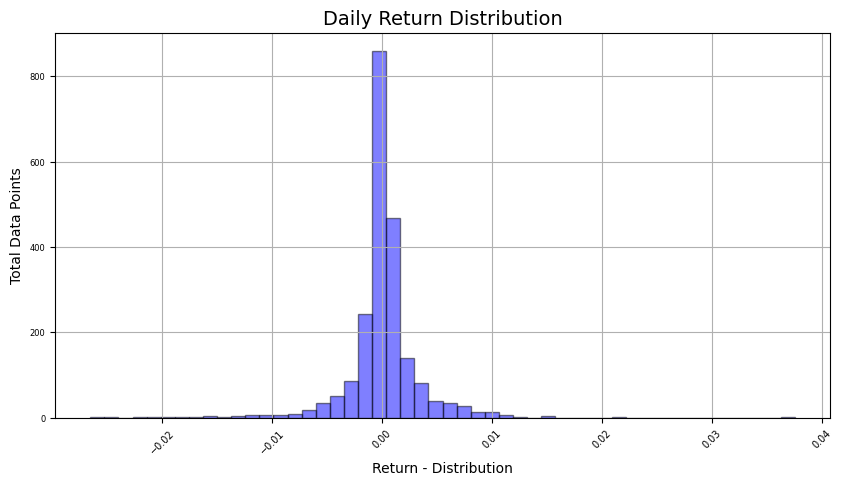

In [30]:
qtsprojectfunctions.ret_hist(returns_leverage[['Portfolio_Daily_Ret']])

We can see that the mean return is clustered around 0 and the cutoff for 1 standard deviation is 0.34%.

In [31]:
qtsprojectfunctions.dp(6)
returns_leverage[['Portfolio_Daily_Ret']].describe()

Portfolio_Daily_Ret
count          2176.000000
mean              0.000083
std               0.003439
min              -0.026557
25%              -0.000734
50%               0.000083
75%               0.000955
max               0.037566

### **Section 2: Return On Capital**

Next, here's the results for the return on capital:

In [32]:
qtsprojectfunctions.dp(4)
Daily_Ret_On_Cap = qtsprojectfunctions.return_stats(returns_leverage[['Daily_Ret_On_Cap']])
Daily_Ret_On_Cap

Mean (Annual)  Volatility (Annual)  Sharpe Ratio (Annual)  \
Daily_Ret_On_Cap         0.0983               0.2089                 0.4705   

                  Max Return (Daily) Max Return (Date)  Min Return (Daily)  \
Daily_Ret_On_Cap              0.1646        2019-01-04             -0.0980   

                 Min Return (Date)  Max Drawdown       Peak     Bottom  \
Daily_Ret_On_Cap        2018-02-05       -0.4231 2013-12-26 2016-02-11   

                 Recovery Date  
Daily_Ret_On_Cap    2018-01-17

These results look considerable better - at least from a mean return standpoint. The volatility is higher, but that's to be expected given we are analyzing only the return on capital. Similar point with the maximum daily return, minimum daily return, and maximum drawdown.

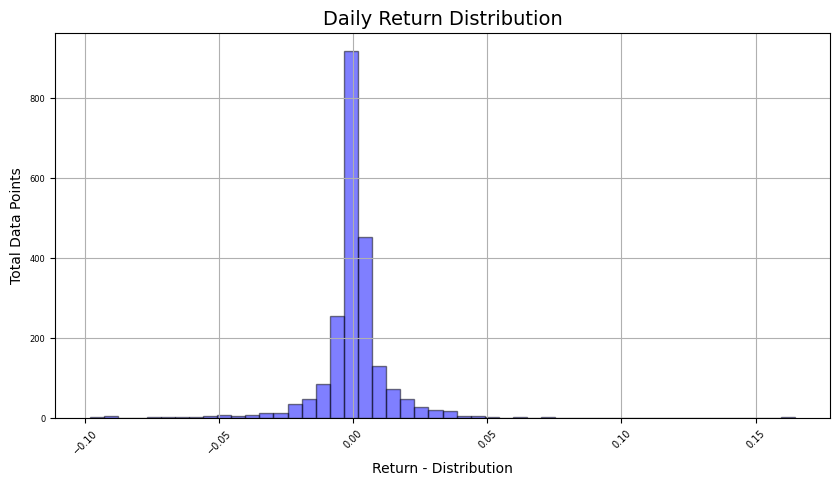

In [33]:
qtsprojectfunctions.ret_hist(returns_leverage[['Daily_Ret_On_Cap']])

Again, the mean return is clustered around 0 with a standard deviation of 1.3%.

In [34]:
qtsprojectfunctions.dp(6)
returns_leverage[['Daily_Ret_On_Cap']].describe()

Daily_Ret_On_Cap
count       2175.000000
mean           0.000390
std            0.013162
min           -0.098043
25%           -0.002721
50%            0.000292
75%            0.003688
max            0.164627

### **Section 3: Returns Comparison**

The following plot compares the total return of the portfolio to the total return on capital.

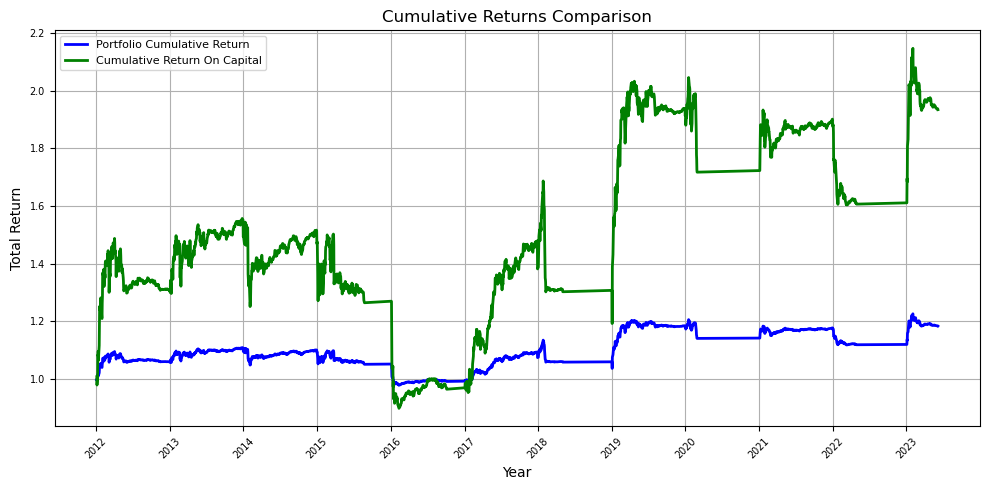

In [35]:
returns_leverage['Portfolio_Cum_Ret'] = (returns_leverage['Portfolio_Daily_Ret'] + 1).cumprod()
returns_leverage['Cum_Ret_On_Cap'] = (returns_leverage['Daily_Ret_On_Cap'] + 1).cumprod()

# Create the initial plot
plt.figure(figsize=(10, 5))

# Plot the first y-axis data
plt.plot(returns_leverage.index, returns_leverage['Portfolio_Cum_Ret'], label = 'Portfolio Cumulative Return', linestyle='-', color='b', linewidth=2)
plt.plot(returns_leverage.index, returns_leverage['Cum_Ret_On_Cap'], label = 'Cumulative Return On Capital', linestyle='-', color='g', linewidth=2)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Year')
plt.ylabel('Total Return')
plt.title('Cumulative Returns Comparison')
# # Define custom formatting function for y-axis labels
# def millions_formatter(x, pos):
#     return '{:.0f}M'.format(x / 1e6)
# plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
plt.xticks(rotation = 45, fontsize = 7)
plt.yticks(fontsize = 7)
plt.tight_layout()
plt.grid(True)
plt.legend(fontsize = 8)
plt.show()

Based on the plot, it can be seen that the leverage amplifies both the updside and downside. The total return on capital is essentially the same as the total portfolio return - only scaled by a factor of 5. The total portfolio return does factor in funding costs, but as we will see later on the funding costs are relatively small due to the risk management that we are implementing.

## **Discussion**

The discussion is broken down into the following parts:

* Section 1: Portfolio Values
* Section 2: Trade Analysis
* Section 3: Benchmark Comparison
* Section 3a: Returns Comparison
* Section 3b: Cumulative Daily Profit & Loss
* Section 3c: Total Trade Profit & Loss
* Section 4: Drawdown Analysis
* Section 5: Funding Costs
* Section 6: Trading Costs

### **Section 1: Portfolio Values**

The following plot contains the total values for positions, portfolio cash, and total portfolio value.

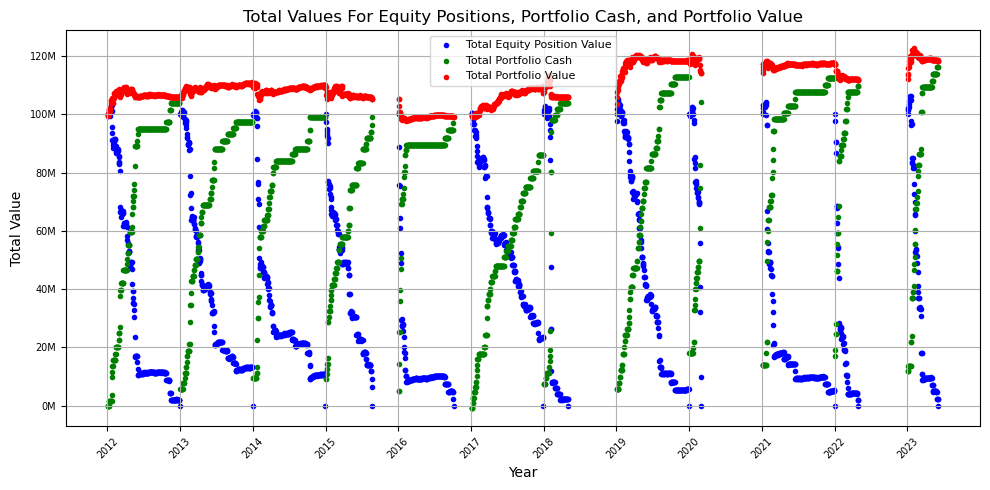

In [36]:
# Create the initial plot
plt.figure(figsize=(10, 5))

# Plot the first y-axis data
plt.scatter(returns_leverage.index, returns_leverage['Total_Position_Value'], label='Total Equity Position Value', marker='.', linestyle='-', color='b', linewidth=1)
plt.scatter(returns_leverage.index, returns_leverage['Portfolio_Cash'], label='Total Portfolio Cash', marker='.', linestyle='-', color='g', linewidth=1)
plt.scatter(returns_leverage.index, returns_leverage['Total_Portfolio_Value'], label='Total Portfolio Value', marker='.', linestyle='-', color='r', linewidth=1)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Year')
plt.ylabel('Total Value')
plt.title('Total Values For Equity Positions, Portfolio Cash, and Portfolio Value')
# Define custom formatting function for y-axis labels
def millions_formatter(x, pos):
    return '{:.0f}M'.format(x / 1e6)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
plt.xticks(rotation = 45, fontsize = 7)
plt.yticks(fontsize = 7)
plt.tight_layout()
plt.grid(True)
plt.legend(fontsize = 8)
plt.show()

This is cumbersome to read and understand, so we will zoom in on 2017. Here's the plot for 2017:

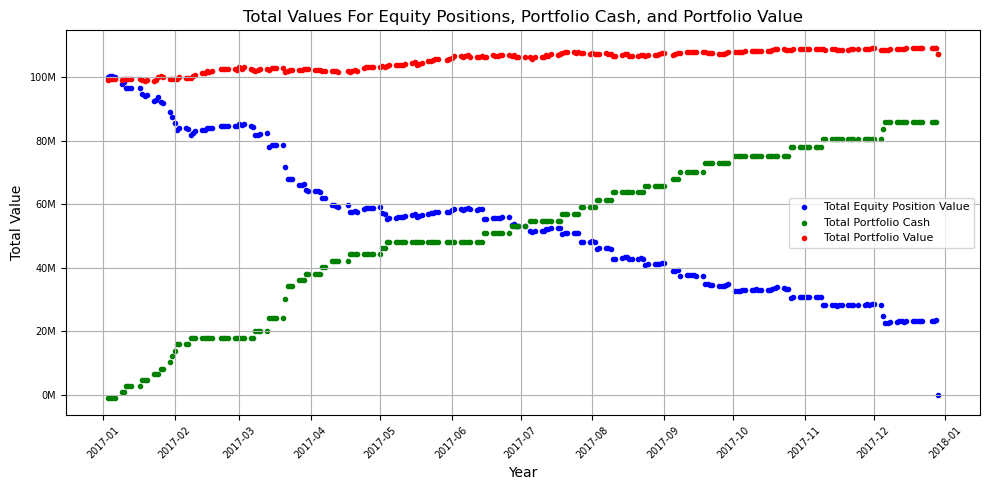

In [37]:
# Create the initial plot
plt.figure(figsize=(10, 5))

start_date = '2017-01-01'
end_date = '2017-12-31'

only_2017 = returns_leverage[(returns_leverage.index >= start_date) & (returns_leverage.index <= end_date)]

# Plot the first y-axis data
plt.scatter(only_2017.index, only_2017['Total_Position_Value'], label='Total Equity Position Value', marker='.', linestyle='-', color='b', linewidth=1)
plt.scatter(only_2017.index, only_2017['Portfolio_Cash'], label='Total Portfolio Cash', marker='.', linestyle='-', color='g', linewidth=1)
plt.scatter(only_2017.index, only_2017['Total_Portfolio_Value'], label='Total Portfolio Value', marker='.', linestyle='-', color='r', linewidth=1)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Change to '%Y-%m' for year and month
plt.xlabel('Year')
plt.ylabel('Total Value')
plt.title('Total Values For Equity Positions, Portfolio Cash, and Portfolio Value')
# Define custom formatting function for y-axis labels
def millions_formatter(x, pos):
    return '{:.0f}M'.format(x / 1e6)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
plt.xticks(rotation = 45, fontsize = 7)
plt.yticks(fontsize = 7)
plt.tight_layout()
plt.grid(True)
plt.legend(fontsize = 8)
plt.show()

From the above plot, we can clearly see what is happening to the total equity value over the course of the year

Recall that we enter the positions on the first trading day of the year, set the stop loss, and let the risk management take over from there. From the above, we can see that the total equity position value (in blue) starts at approximately $ 100 million and slowly decreases as positions are exited through the stop loss. When positions are exited, the cash becomes portfolio cash (in green). As the year progresses, we can see that as the total equity value decreases the total portfolio cash corresponds with an increase.

Any positions that are open at the end of the year are closed on the last trading day of the year.

Together, the total equity value and total portfolio cash make up the total portfolio value (in red). Any gains that are made throughout the year are harvested and the trading strategy starts with $ 100 million the next year.

### **Section 2: Trade Analysis**

We'll now do some analysis on the trades that took place during the strategy.

In [38]:
trades = filtered_prices[['ticker', 'entry_date', 'entry_price', 'exit_date', 'exit_price', 'Trade_PnL', 'Stop_Loss']]
trades = trades[trades['Stop_Loss'] == 'Stop Loss Or Exit Position']

In [39]:
(trades['exit_price'] > trades['entry_price']).value_counts()

False    335
True     264
dtype: int64

The first thing we can see is that of the 599 trades, 264 of them were profitable and 335 of them were not. We didn't have a strong expectation of what the proportions would be between profitable and non-profitable trades.

In [40]:
trades['ticker'].unique()

array(['PHG', 'NEM', 'COF', 'GLW', 'NOK', 'HES', 'JNPR', 'MT', 'SCCO',
       'FCX', 'IBN', 'AMAT', 'HAL', 'AFL', 'BHP', 'CAT', 'CVE', 'SHG',
       'GGB', 'BSBR', 'CEO', 'OXY', 'F', 'CVX', 'SHEL', 'AAPL', 'BIDU',
       'BLK', 'COP', 'TM', 'TXN', 'JPM', 'CAJPY', 'TEVA', 'KR', 'ISRG',
       'BA', 'HSBC', 'INTC', 'ADBE', 'AXP', 'TSM', 'XOM', 'USB', 'UPS',
       'T', 'D', 'KO', 'SPG', 'L', 'GM', 'AU', 'TECK', 'DB', 'EC', 'LVS',
       'PPG', 'BP', 'EOG', 'NUE', 'MET', 'EBAY', 'EQNR', 'MFG', 'IMO',
       'CNQ', 'SCHW', 'CMI', 'ETN', 'BKR', 'SAP', 'MSI', 'AEP', 'BRFS',
       'PARA', 'BCE', 'BUD', 'WYNN', 'CNI', 'EPD', 'CME', 'PCAR', 'BAX',
       'TFC', 'BKNG', 'LIN', 'MRK', 'CHU', 'CB', 'CMG', 'DLTR', 'MPC',
       'TJX', 'ING', 'LYB', 'MA', 'PUK', 'CBD', 'DG', 'FMX', 'SMFG',
       'DEO', 'NMR', 'TRV', 'GS', 'MO', 'MUFG', 'FDX', 'V', 'TRI', 'TS',
       'FMS', 'CMCSA', 'GPS', 'ACN', 'BAC', 'AMGN', 'PFE', 'MAR', 'HON',
       'ITW', 'MSFT', 'ALL', 'AMT', 'ORLY', 'CPRI', 'RRC', 'SAN', 

In [41]:
len(trades['ticker'].unique())

366

The second thing we can observe is that the entire strategy runs on 366 equities, broken out as follows by profit and loss.

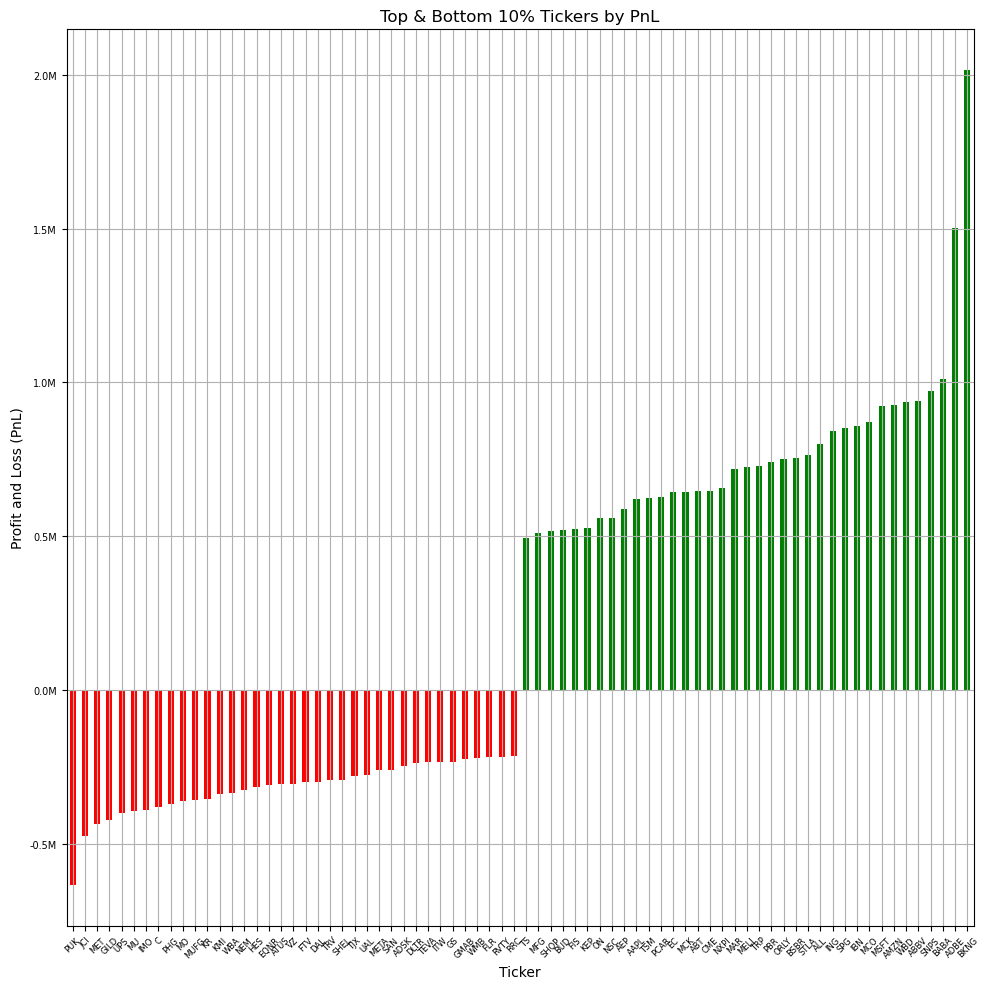

In [42]:
# Sum of Daily PnL by ticker and calculate quantiles for filtering
daily_pnl_sum = trades.groupby('ticker')['Trade_PnL'].sum()
quantiles = daily_pnl_sum.quantile([0.10, 0.90])

# Filter and combine top 10% and bottom 10% PnLs, then sort
pnl_filtered = pd.concat([
    daily_pnl_sum[daily_pnl_sum <= quantiles[0.10]],
    daily_pnl_sum[daily_pnl_sum >= quantiles[0.90]]
]).sort_values()

# Plotting
plt.figure(figsize=(10, 10))
pnl_filtered.plot.bar(color=['red' if x < 0 else 'green' for x in pnl_filtered], title='Top & Bottom 10% Tickers by PnL')
plt.xlabel('Ticker')
plt.ylabel('Profit and Loss (PnL)')
# Define custom formatting function for y-axis labels
def millions_formatter(x, pos):
    return '{:.1f}M'.format(x / 1e6)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
plt.xticks(rotation = 45, fontsize = 6)
plt.yticks(fontsize = 7)
plt.tight_layout()
plt.grid(True)
plt.show()

fig = plt.show()

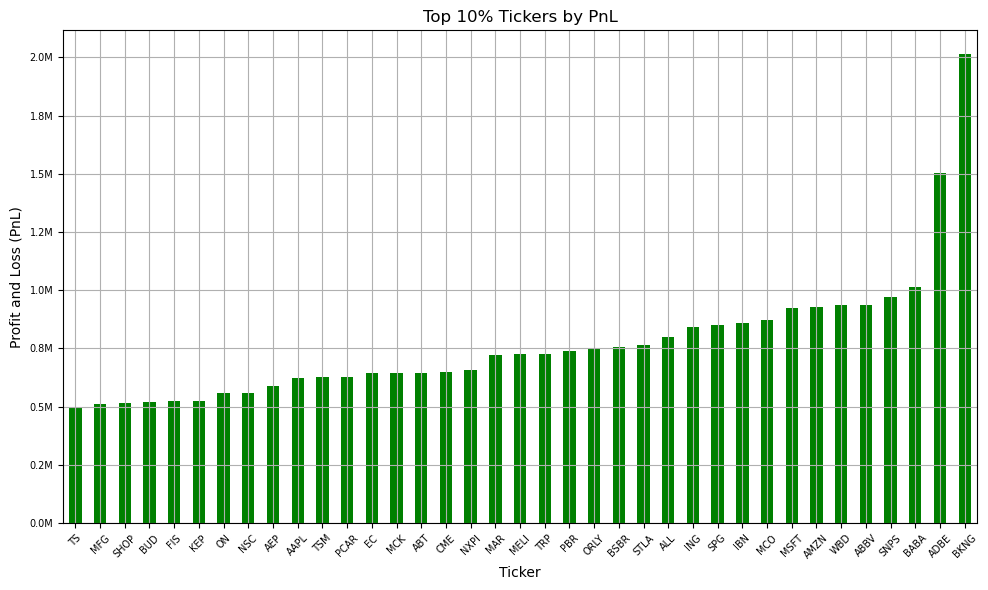

In [43]:
# Sum of Daily PnL by ticker and calculate quantiles for filtering
daily_pnl_sum = trades.groupby('ticker')['Trade_PnL'].sum()
quantiles = daily_pnl_sum.quantile([0.90])

# Filter and combine top 10% and bottom 10% PnLs, then sort
pnl_filtered = pd.concat([
    daily_pnl_sum[daily_pnl_sum >= quantiles[0.90]]
]).sort_values()

# Plotting
plt.figure(figsize=(10, 6))
pnl_filtered.plot.bar(color=['red' if x < 0 else 'green' for x in pnl_filtered], title='Top 10% Tickers by PnL')
plt.xlabel('Ticker')
plt.ylabel('Profit and Loss (PnL)')
# Define custom formatting function for y-axis labels
def millions_formatter(x, pos):
    return '{:.1f}M'.format(x / 1e6)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
plt.xticks(rotation = 45, fontsize = 7)
plt.yticks(fontsize = 7)
plt.tight_layout()
plt.grid(True)
plt.show()

fig = plt.show()

We can see that the greatest contribution to the profits comes from BKNG - Booking Holdings Inc. Looking at a chart of BKNG over the past 13 years provides some insights as to why. This is precisely the type of outlier that we are looking to capture.

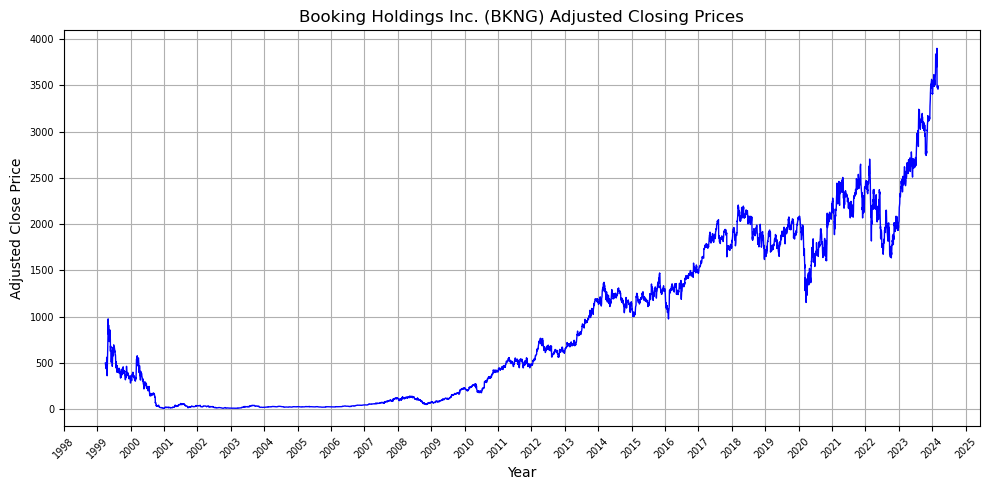

In [44]:
bkng = qm_prices[qm_prices['ticker'] == 'BKNG'][['adj_close']].reset_index()
bkng['date'] = pd.to_datetime(bkng['date'])

# Create the initial plot
plt.figure(figsize=(10, 5))

# Plot the first y-axis data
plt.plot(bkng['date'], bkng['adj_close'], linestyle='-', color='b', linewidth=1)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Year')
plt.ylabel('Adjusted Close Price')
plt.title('Booking Holdings Inc. (BKNG) Adjusted Closing Prices')
plt.xticks(rotation = 45, fontsize = 7)
plt.yticks(fontsize = 7)
plt.tight_layout()
plt.grid(True)
plt.show()

### **Section 3: Benchmark Comparison**

We will use the S&P 500 index as a benchmark to compare against - specifically the SPDR S&P 500 ETF Trust with ticker symbol 'SPY'.

In [45]:
# SPY df
spy = qm_prices[qm_prices['ticker'] == 'SPY']
filtered_prices['date'] = pd.to_datetime(filtered_prices['date'])
spy.index = pd.to_datetime(spy.index)
# our first trades are in 2012
spy = spy[spy.index >= '2012']

#### **Section 3a: Returns Comparison**

Here we have the returns comparison between the porfolio return, the return on capital, and the return for SPY.

In [46]:
# SPY buy and hold (hodl)
pd.set_option('display.float_format', lambda x: '%.2f' % x)  # Change '.2f' as needed for your precision
spy_buy_n_hold = spy.copy()
spy_buy_n_hold['SPY_Daily_Ret'] = spy_buy_n_hold['adj_close'].pct_change()
spy_buy_n_hold['Cum_Return'] = (1 + spy_buy_n_hold['SPY_Daily_Ret']).cumprod()
spy_buy_n_hold['shares'] = int(20000000 / spy_buy_n_hold.iloc[0]['adj_close'])
spy_buy_n_hold['dollar_value'] = spy_buy_n_hold['shares'] * spy_buy_n_hold['adj_close']
spy_buy_n_hold['daily_pnl'] = spy_buy_n_hold['dollar_value'].diff()
spy_buy_n_hold_ret = qtsprojectfunctions.return_stats(spy_buy_n_hold[['SPY_Daily_Ret']])
ret_comp = pd.concat([Portfolio_Daily_Ret, Daily_Ret_On_Cap, spy_buy_n_hold_ret])
qtsprojectfunctions.dp(4)
ret_comp

Mean (Annual)  Volatility (Annual)  \
Portfolio_Daily_Ret         0.0210               0.0546   
Daily_Ret_On_Cap            0.0983               0.2089   
SPY_Daily_Ret               0.1469               0.1666   

                     Sharpe Ratio (Annual)  Max Return (Daily)  \
Portfolio_Daily_Ret                 0.3850              0.0376   
Daily_Ret_On_Cap                    0.4705              0.1646   
SPY_Daily_Ret                       0.8820              0.0906   

                    Max Return (Date)  Min Return (Daily) Min Return (Date)  \
Portfolio_Daily_Ret        2019-01-04             -0.0266        2018-02-05   
Daily_Ret_On_Cap           2019-01-04             -0.0980        2018-02-05   
SPY_Daily_Ret              2020-03-24             -0.1094        2020-03-16   

                     Max Drawdown       Peak     Bottom Recovery Date  
Portfolio_Daily_Ret       -0.1178 2013-12-26 2016-02-11    2018-01-17  
Daily_Ret_On_Cap          -0.4231 2013-12-26 2016-02-11    2018-01-17  
SPY_Daily_Ret             -0.3370 2020-02-19 2020-03-23    2020-08-10

There are a couple of important points here.

First, the annual returns for SPY beat the return on capital by nearly 5%. The historical annual return for the S&P 500 is between 9 and 10%, so we can confidently say that the return on capital is matching the historical benchmark. However for the sample from 2012 to the present, SPY has performed significantly better than it's historical average.

Second, the volatility of SPY is better than that of the ROC by approximately 3%, but significantly higher than the volatility that we are experiencing as part of the total portfolio.

Next, we will compare the cumulative returns for all 3.

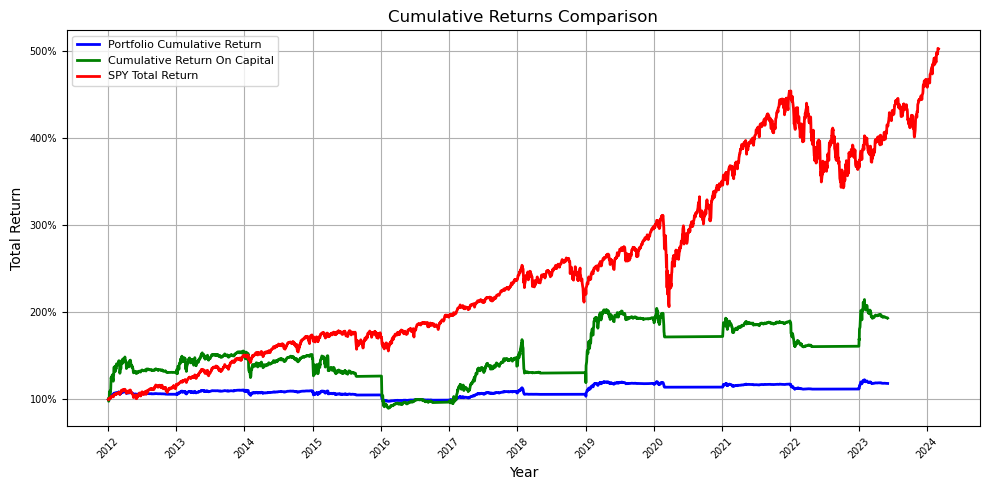

In [47]:
# Create the initial plot
plt.figure(figsize=(10, 5))

# Plot the first y-axis data
plt.plot(returns_leverage.index, returns_leverage['Portfolio_Cum_Ret'], label='Portfolio Cumulative Return', linestyle='-', color='b', linewidth=2)
plt.plot(returns_leverage.index, returns_leverage['Cum_Ret_On_Cap'], label='Cumulative Return On Capital', linestyle='-', color='g', linewidth=2)
plt.plot(spy_buy_n_hold.index, spy_buy_n_hold['Cum_Return'], label='SPY Total Return', linestyle='-', color='r', linewidth=2)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Year')
plt.ylabel('Total Return')

# Formatting y-axis ticks as percentages
def percent_formatter(x, pos):
    return '{:.0f}%'.format(x * 100)

plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))

plt.title('Cumulative Returns Comparison')
plt.xticks(rotation=45, fontsize=7)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.grid(True)
plt.legend(fontsize=8)
plt.show()

This chart gives us an idea of the impact of an additional 5% / year on an annual return. By the middle of 2023, the return on capital is roughly 2x our starting capital, but the return on SPY is roughly 5x!

It can also be seen from this plot that there are long stretches where we do not have any positions. This is a result of our stop loss taking affect, and we can see that the points in time where the returns are flat coincide with the points in time when SPY has recently gone through a drawdown.

Finally, let's look at the correlations between SPY returns and our portfolio returns.

In [48]:
strategy_and_spy_returns = pd.merge(returns_leverage[['Portfolio_Daily_Ret']],spy_buy_n_hold[['SPY_Daily_Ret']], 
                                    left_on=returns_leverage.index, right_on=spy_buy_n_hold.index).set_index('key_0')
strategy_and_spy_returns.corr()

Portfolio_Daily_Ret  SPY_Daily_Ret
Portfolio_Daily_Ret               1.0000         0.6074
SPY_Daily_Ret                     0.6074         1.0000

As can be seen from above, there is some correlation between the two, but there is certainly diversification benefits.

#### **Section 3b: Cumulative Daily Profit & Loss**

The following plot compares the cumulative daily profit and loss for SPY vs our trading strategy.

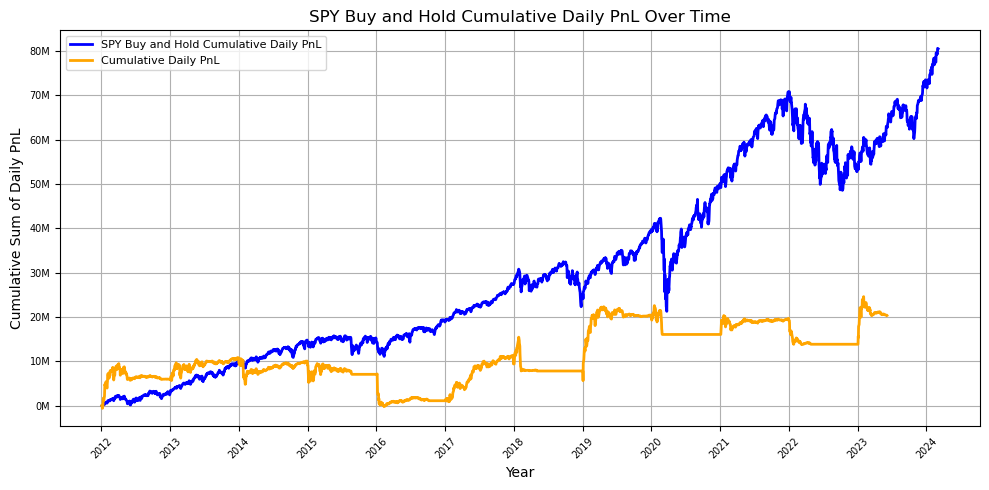

In [49]:
spy_daily_pnl_sum = spy_buy_n_hold.groupby(spy_buy_n_hold.index)['daily_pnl'].sum()
spy_cumulative_pnl = spy_daily_pnl_sum.cumsum()

filtered_prices['date'] = pd.to_datetime(filtered_prices['date'])
daily_pnl_sum = filtered_prices.groupby('date')['Daily_PnL'].sum()
cumulative_pnl = daily_pnl_sum.cumsum()

plt.figure(figsize=(10, 5))
plt.plot(spy_cumulative_pnl.index, spy_cumulative_pnl.values, label='SPY Buy and Hold Cumulative Daily PnL', linestyle='-', color='b', linewidth=2)
plt.plot(cumulative_pnl.index, cumulative_pnl.values, label='Cumulative Daily PnL', linestyle='-', color='orange', linewidth=2)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Year')
plt.ylabel('Cumulative Sum of Daily PnL')
plt.title('SPY Buy and Hold Cumulative Daily PnL Over Time')
# Define custom formatting function for y-axis labels
def millions_formatter(x, pos):
    return '{:.0f}M'.format(x / 1e6)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
plt.xticks(rotation = 45, fontsize = 7)
plt.yticks(fontsize = 7)
plt.tight_layout()
plt.grid(True)
plt.legend(fontsize = 8)
plt.show()

It is important to note that the data for SPY does not factor in taking any cash out of the strategy, but our trading strategy does include siphoning off profits at the end of every year.

#### **Section 3c: Total Trade Profit & Loss**

Here we have a plot to show the cumulative profit and loss over the length of the trading strategy.

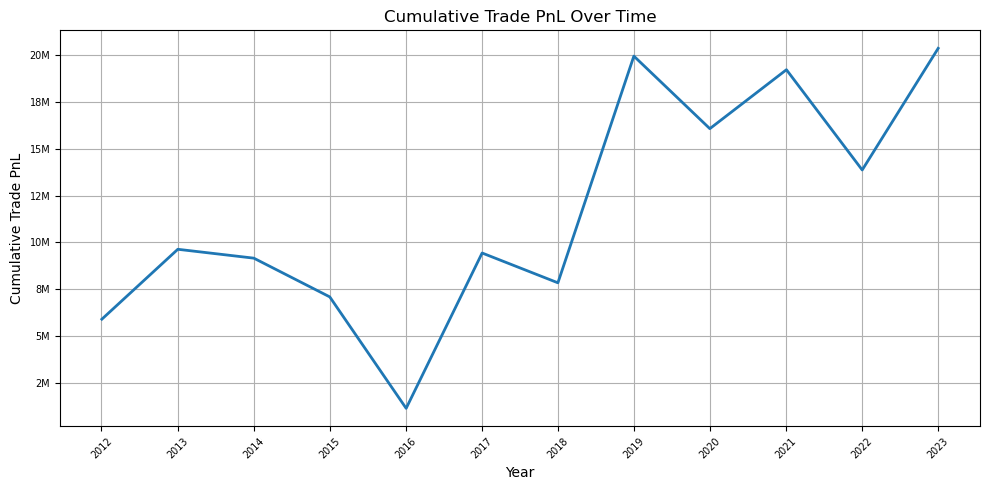

In [50]:
trades['entry_date'] = pd.to_datetime(trades['entry_date'])
trades.sort_values(by='entry_date', inplace=True)

trade_pnl_sum = filtered_prices.groupby('entry_date')['Daily_PnL'].sum()
cumulative_pnl = trade_pnl_sum.cumsum()


# Plotting
plt.figure(figsize=(10, 5))
plt.plot(cumulative_pnl.index, cumulative_pnl.values, label='Cumulative Trade PnL', linewidth=2)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Year')
plt.ylabel('Cumulative Trade PnL')
plt.title('Cumulative Trade PnL Over Time')
# Define custom formatting function for y-axis labels
def millions_formatter(x, pos):
    return '{:.0f}M'.format(x / 1e6)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
plt.xticks(rotation = 45, fontsize = 7)
plt.yticks(fontsize = 7)
plt.tight_layout()
plt.grid(True)
plt.show()

Here's similar data, but in a bar chart format.

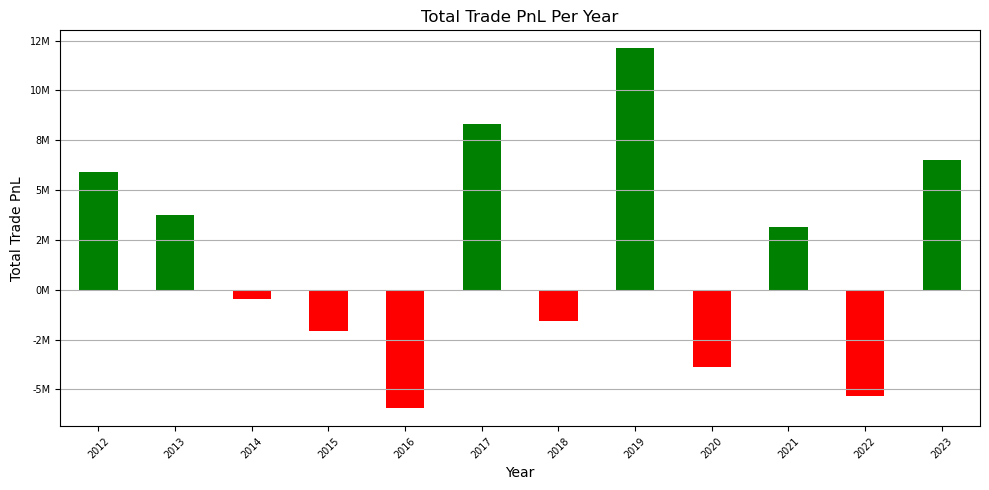

In [51]:
trades['entry_date'] = pd.to_datetime(trades['entry_date'])
trades['entry_year'] = trades['entry_date'].dt.year
yearly_pnl = trades.groupby('entry_year')['Trade_PnL'].sum()
plt.figure(figsize=(10, 5))
yearly_pnl.plot(kind='bar', color=['red' if x < 0 else 'green' for x in yearly_pnl])
plt.xlabel('Year')
plt.ylabel('Total Trade PnL')
plt.title('Total Trade PnL Per Year')
# Define custom formatting function for y-axis labels
def millions_formatter(x, pos):
    return '{:.0f}M'.format(x / 1e6)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
plt.xticks(rotation = 45, fontsize = 7)
plt.yticks(fontsize = 7)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

Finally, a similar chart for SPY, showing the cumulative profit and loss over the length of the dataset.

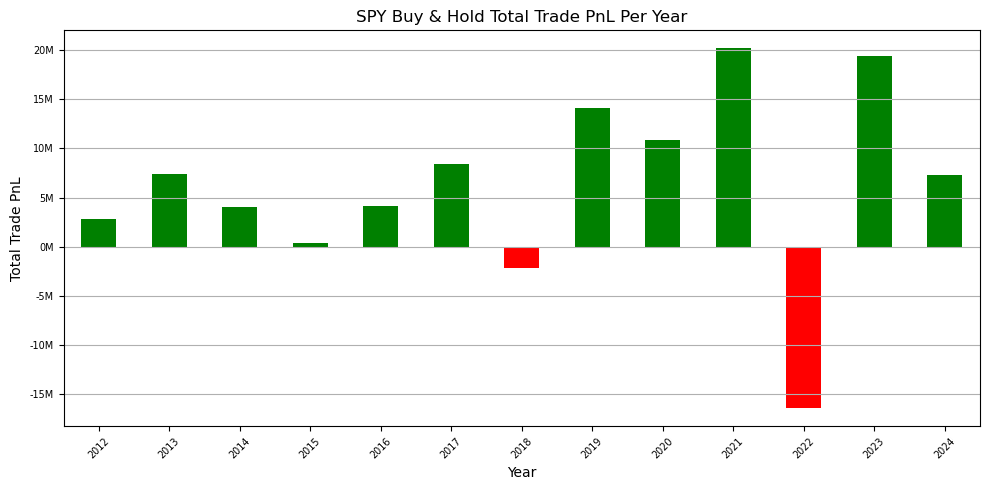

In [52]:
spy_buy_n_hold['entry_year'] = spy_buy_n_hold.index.year
spy_yearly_pnl = spy_buy_n_hold.groupby('entry_year')['daily_pnl'].sum()
plt.figure(figsize=(10, 5))
spy_yearly_pnl.plot(kind='bar', color=['red' if x < 0 else 'green' for x in spy_yearly_pnl])
plt.xlabel('Year')
plt.ylabel('Total Trade PnL')
plt.title('SPY Buy & Hold Total Trade PnL Per Year')
# Define custom formatting function for y-axis labels
def millions_formatter(x, pos):
    return '{:.0f}M'.format(x / 1e6)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
plt.xticks(rotation = 45, fontsize = 7)
plt.yticks(fontsize = 7)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

### **Section 4: Drawdown Analysis**

Here we have the analysis of the maximum drawdown over the life of the trading strategy. 

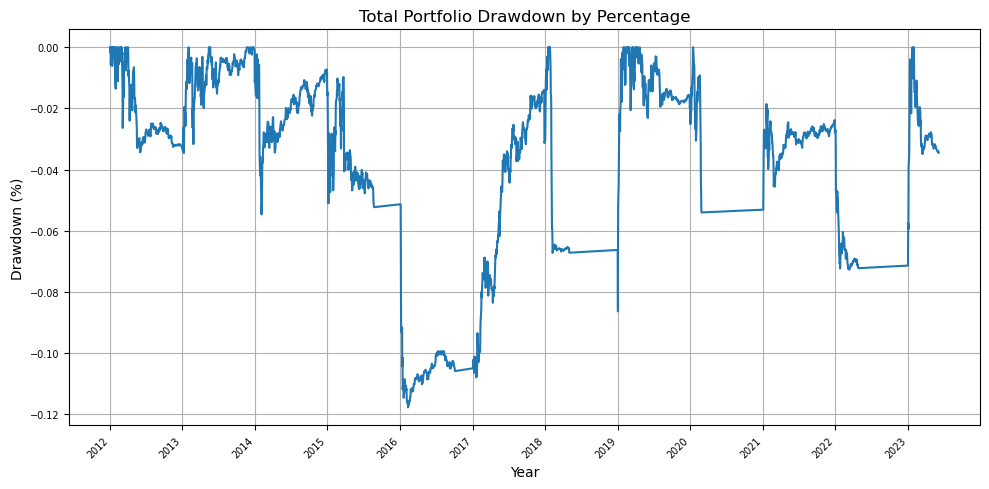

In [53]:
rolling_max = returns_leverage['Total_Portfolio_Value'].cummax()
drawdown = (returns_leverage['Total_Portfolio_Value'] - rolling_max) / rolling_max
# Plot drawdown
plt.figure(figsize=(10, 5))
drawdown.plot()
plt.title('Total Portfolio Drawdown by Percentage')
plt.xlabel('Year')
plt.ylabel('Drawdown (%)')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation = 45, fontsize = 7)
plt.yticks(fontsize = 7)
plt.tight_layout()
plt.grid(True)
plt.show()

Recall from our returns analysis that the maximum drawdown of -11.78% happens on 2/11/2016. The strategy recovers by early 2018.

### **Section 5: Funding Costs**

Here we have a comparison between the cumulative funding costs and the Fed Funds Rate.

In [54]:
returns_leverage['Cum_Funding_Cost']
fed_funds = fetch_fed_funds()
fed_funds = fed_funds[fed_funds.index >= '2011-01-01']

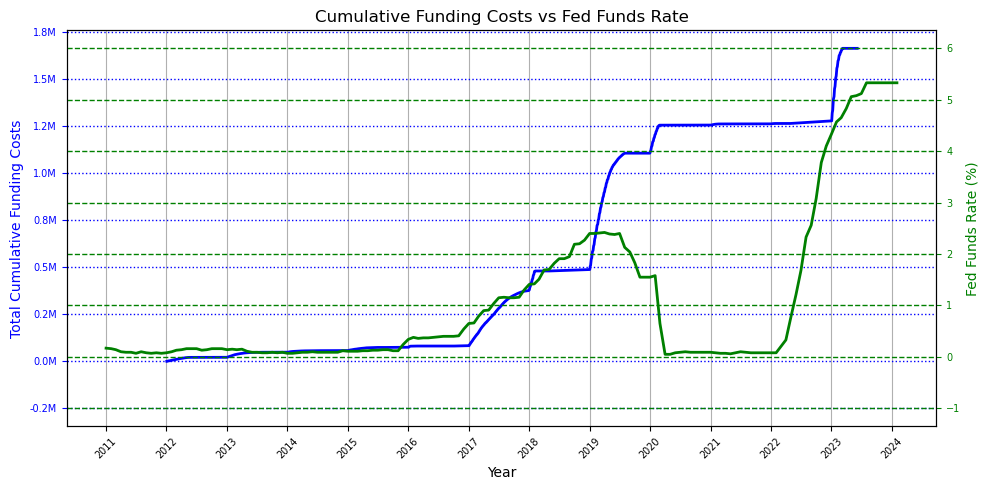

In [55]:
# Create the initial plot
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot the first y-axis data
ax1.plot(returns_leverage.index, returns_leverage['Cum_Funding_Cost'], linestyle='-', color='b', linewidth=2)
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Cumulative Funding Costs', color='b')
ax1.tick_params('y', colors='b')
ax1.tick_params(axis='x', rotation=45, labelsize=7)
ax1.tick_params(axis='y', labelsize=7)
for y_tick in ax1.get_yticks():
    ax1.axhline(y_tick, color='b', linestyle=':', linewidth=1)
ax1.grid(axis='x')

# Create the second y-axis
ax2 = ax1.twinx()
ax2.plot(fed_funds.index, fed_funds['Fed_Funds_Annual'], linestyle='-', color = 'g', linewidth=2)
ax2.set_ylabel('Fed Funds Rate (%)', color='g')
ax2.tick_params('y', colors='g')
ax2.tick_params(axis='y', labelsize=7)
for y_tick in ax2.get_yticks():
    ax2.axhline(y_tick, color='g', linestyle='--', linewidth=1)

# Define custom formatting function for y-axis labels
def millions_formatter(x, pos):
    return '{:.1f}M'.format(x / 1e6)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Title and grid
plt.title('Cumulative Funding Costs vs Fed Funds Rate')
plt.tight_layout()
plt.show()

It can be seen that the funding costs were very low up until 2017 when interest rates were also very low, but began to increase in early 2017. Again they were low in early 2020 (after the COVID 19 pandemic), but began increasing in early 2022 and have increased signficantly since.

Funding costs is an unknown risk and could certainly affect the viability of the strategy going forward.

### **Section 6: Trading Costs**

Here we have a plot of the cumulative trading costs for the entire length of the strategy.

In [56]:
returns_leverage['Cum_Trading_Costs'] = abs(returns_leverage['Trading_Costs']).cumsum()

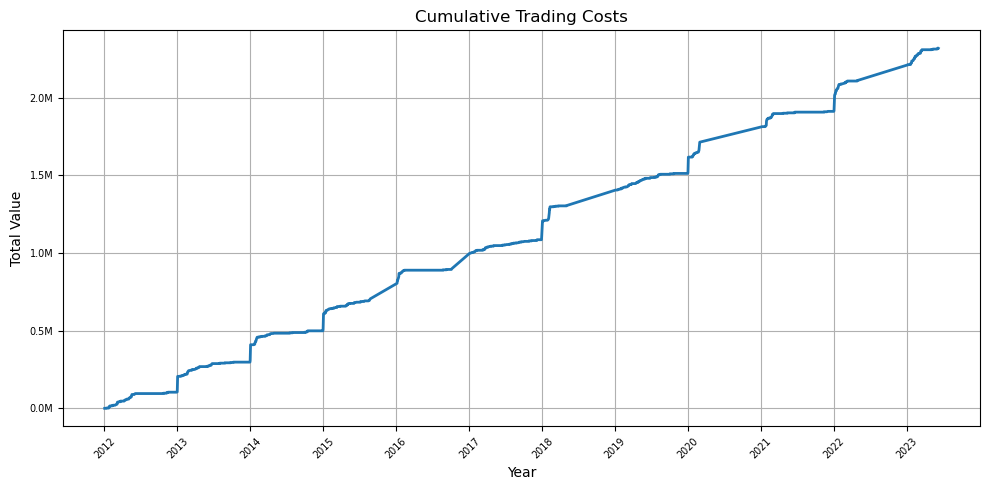

In [57]:
# Create the initial plot
plt.figure(figsize=(10, 5))

# Plot the first y-axis data
plt.plot(returns_leverage.index, returns_leverage['Cum_Trading_Costs'], linewidth=2)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Year')
plt.ylabel('Total Value')
plt.title('Cumulative Trading Costs')
# Define custom formatting function for y-axis labels
def millions_formatter(x, pos):
    return '{:.1f}M'.format(x / 1e6)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
plt.xticks(rotation = 45, fontsize = 7)
plt.yticks(fontsize = 7)
plt.tight_layout()
plt.grid(True)
plt.show()

Given that we are starting each year with nearly the same amount of capital, we expect the initial trading costs to be identical. Throughout the year, as positions sell off, there will be slight variations from year to year but in general trading costs should be very predictable for this strategy. 

## **Conclusion**

In the above analysis we compared our strategy to the S&P 500 frequently. The S&P is a benchmark and while it is useful in some respects, we wanted to design a strategy that does not mirror the S&P and offers a different sort of functionality. Taking this into account, we have come up with the below interpretation of our strategy, which demonstrates its legitimate use cases and benefits:

1. **Capital Preservation**
* We implemented a stop loss mechanism which prevents any one position from losing more than 10%, this allowed us to achieve a maximum drawdown of 12% in our portfolio which was substantially lower than the S&Ps of 34%.
* You will note that our capital itself did have a lower drawdown than the S&Ps, but this is the return on our capital not the actual investment itself (you can see the down years where this occurs)
* This is actually different than the S&P because this amount is based on our returns and not on the total portfolio value, so the 42% max drawdown is a bit misleading as it is not reflective of our entire position

2. **Tax advantaged cash flows**
* Our strategy sells out of all positions on an annualized basis, distributing gains/losses, which means we are effectively generating capital gains/losses annually
* We generate around $20mm over the life of the strategy, which annualizes to a yearly return of 9.83%, this is lower than the S&Ps return but again our strategy fundamentally differs and serves a different purpose than simply investing in the S&P
* The strategy generates cash flows annually and allows investors to carry forward their losses, offsetting large portions of capital gains taxes, and allowing for what becomes essentially a high yield portfolio, while also benefiting from the rise in equities with higher distributions

3. **Lower annual volatility/risk**
* Because we are selling out of positions yearly and buying back in we tend to experience less volatility than the S&P as well, which is attractive for certain investors; the volatility within our portfolio during the year was 5.5% while the S&P was 17%
* The cash flows/returns were a more volatile than the S&P, but our portfolio, or initial capital pool was not, however this is offset by the aforementioned fact that investors can carry forward losses, implying that true losses are lower than detailed above

Based on the above and the detailed analysis in the notebook, we believe we have developed a profitable strategy. This approach is distinct from a typical equity buy-and-hold strategy and offers investors with specific risk appetites alternative avenues to fixed income for generating tax-advantaged cash flows.